In [58]:
import matplotlib.pyplot as plt

from pyspark.sql import (
    functions as F,
    Row,
    SparkSession,
)

In [59]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()
spark

# Overview

In [60]:
review_fp = "hdfs://namenode:9000/preprocessed"
df = spark.read.parquet(review_fp, header=True, inferSchema=True)
df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 4016
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miáº¿ng gÃ  105k n...|     1|          0| negative|
|Tháº­t tuyá»‡t vá»›i gÃ ...|     5|          0| positive|
|GÃ  Æ°á»›p vá»«a vá»‹ , m...|     5|          0| positive|
|QuÃ¡n sáº¡ch , Ä‘áº¹p ,...|     5|          0| positive|
|NhÃ¢n_viÃªn bá»± con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [61]:
# Total Rows & Columns
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}\n")

print('Overview of columns:')
df.describe().show()

print('Count by rating:')
df.groupBy('rating').count().orderBy('rating').show()

print('Count by place_index:')
df.groupBy('place_index').count().orderBy('place_index').show()

Total rows: 4016
Total columns: 4

Overview of columns:
+-------+--------------------+-----------------+------------------+---------+
|summary|              review|           rating|       place_index|sentiment|
+-------+--------------------+-----------------+------------------+---------+
|  count|                4016|             4016|              4016|     4016|
|   mean|                NULL|4.145916334661354|10.418077689243027|     NULL|
| stddev|                NULL|1.528190314011222| 6.318547832750799|     NULL|
|    min|( khÃ´ng chá»‰ chi_n...|                1|                 0| negative|
|    max|               ðŸ¥³ ðŸ™Œ|                5|                21| positive|
+-------+--------------------+-----------------+------------------+---------+

Count by rating:
+------+-----+
|rating|count|
+------+-----+
|     1|  669|
|     2|   92|
|     3|  148|
|     4|  182|
|     5| 2925|
+------+-----+

Count by place_index:
+-----------+-----+
|place_index|count|
+-----------+-----+

# *Distribution of ratings*

Based on the chart, itâ€™s clear that most users gave 5-star ratings (**2624 reviews**), showing that they were really satisfied with the service.\
The number of lower ratings like 1 (**496 reviews**), 2 (**68 reviews**), or 3 (**113 reviews**) stars is quite small in comparison, implying that only a few people had negative experiences.

The strong concentration in high ratings suggests that the overall user feedback is very positive.

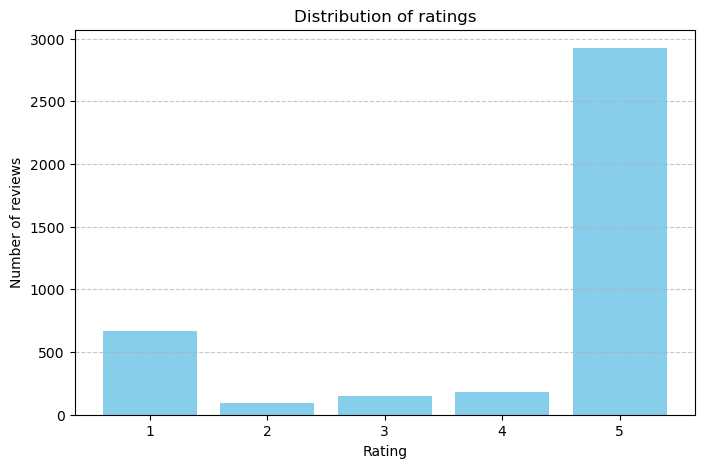

In [62]:
rating_distribution = df.groupBy('rating').count().orderBy('rating')

data = rating_distribution.collect()
ratings = [row['rating'] for row in data]
counts = [row['count'] for row in data]

plt.figure(figsize=(8, 5))
plt.title('Distribution of ratings')

plt.bar(ratings, counts, color='skyblue')

plt.xlabel('Rating')
plt.xticks(ratings)
plt.ylabel('Number of reviews')

plt.grid(axis='y', linestyle='--', alpha=0.7);

# `place_index` *by average rating*

From the chart, we can see that the average ratings across different places are generally high, most of them above 4.\
This shows that users tend to be quite satisfied overall. Place index 7 stands out with the highest average, close to 5 stars, while place 8 has the lowest, of below 4 stars.

The moderate variation between places suggests that service quality is fairly consistent, though some places clearly perform better than others.

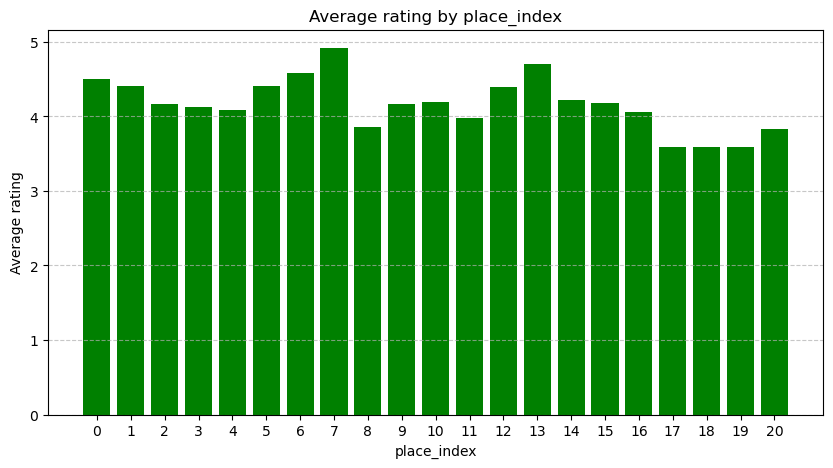

In [63]:
av_rating_df = df.groupBy('place_index').avg('rating').orderBy('place_index').toPandas()

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)

ax.set_title('Average rating by place_index')
ax.bar(av_rating_df.index, av_rating_df['avg(rating)'], color='green')

ax.set_xticks(av_rating_df.index)
ax.set_xlabel('place_index')
ax.set_ylabel('Average rating')
plt.grid(axis='y', linestyle='--', alpha=0.7);

# Word Count with RDD's Map&Reduce

To better understand the common themes in the reviews, we analyzed the commonly used words within the reviews.

In [64]:
import re
from string import punctuation

import pandas as pd
import numpy as np

The list of Vietnamese stopwords are provided at [`stopwords/vietnamese-stopwords`](https://github.com/stopwords/vietnamese-stopwords)

In [ ]:
!wget -qO vietnamese-stopwords-dash.txt https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt

stopwords_path = "vietnamese-stopwords-dash.txt"
with open(stopwords_path, encoding='utf-8') as file:
    stopwords = {line.strip() for line in file}

In [67]:
def word_tokenize(row):
    return [(
        word.lower(), row['rating'],
        row['sentiment'], row['place_index']
        ) for word in row['review'].split()
    ]

tokenized_rdd = df.rdd.flatMap(word_tokenize)

In [68]:
count_global = tokenized_rdd.map(lambda row: ((row[0], ), 1))
wc_global = count_global.reduceByKey(lambda x, y: x + y)

# By rating
count_by_rating = tokenized_rdd.map(lambda row: ((row[0], row[1]), 1))
wc_rating = count_by_rating.reduceByKey(lambda x, y: x + y)

# By sentiment & place_index
count_by_sent_place = tokenized_rdd.map(lambda row: ((row[0], row[2], row[3]), 1))
wc_sent_place = count_by_sent_place.reduceByKey(lambda x, y: x + y)

# By sentiment
count_by_sent = tokenized_rdd.map(lambda row: ((row[0], row[2]), 1))
wc_sent = count_by_sent.reduceByKey(lambda x, y: x + y)

In [69]:
stopwords.update(set(punctuation))

def is_valid_key(key):
    # single string (wc_global)
    if isinstance(key, str): word = key
    # tuple (wc_rating, wc_sent_place,...)
    elif isinstance(key, tuple): word = key[0]
    return (
        word not in stopwords and
        not re.fullmatch(r'^\W+$', word) and # remove punctuation
        not re.fullmatch(r'^\d+$', word) # remove numbers
    )

filtered_global = wc_global.filter(lambda row: is_valid_key(row[0][0]))
filtered_rating = wc_rating.filter(lambda row: is_valid_key(row[0][0]))
filtered_sent = wc_sent.filter(lambda row: is_valid_key(row[0][0]))
filtered_sent_place = wc_sent_place.filter(lambda row: is_valid_key(row[0][0]))

# Visualizing the Word Count

## Global Word Cloud
Word Cloud for all words in reviews

In [ ]:
from wordcloud import WordCloud

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='viridis')

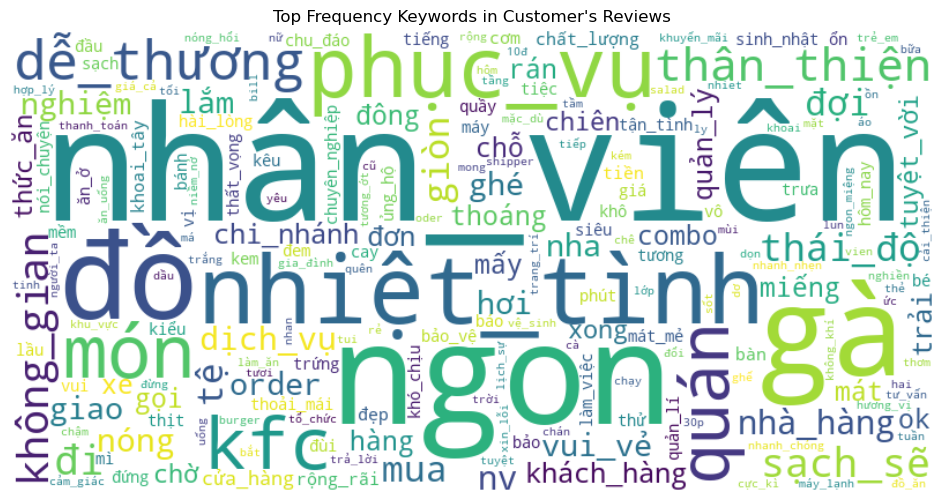

In [72]:
wordcloud_dict = {key[0]: val for key, val in filtered_global.collect()}

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud.generate_from_frequencies(wordcloud_dict), interpolation='bilinear')
plt.axis("off")
plt.title("Top Frequency Keywords in Customer's Reviews");

The word cloud shows that users often mention aspects related to service quality and food:

- In terms of **service**, words like 'nhÃ¢n_viÃªn', 'phá»¥c_vá»¥', 'nhiá»‡t_tÃ¬nh', 'thÃ¢n_thiá»‡n', and 'dá»…_thÆ°Æ¡ng' appear frequently, indicating a generally positive impression of customer service.
- In terms of **food**, words such as 'ngon', 'gÃ ', 'giÃ²n', 'mÃ³n', and 'chiÃªn' suggest that many users were satisfied with the food quality, especially chicken â€“ a key product of KFC.
- Some negative or neutral words like 'tá»‡', 'Ä‘á»£i' are present, but with lower frequency, implying negative experiences exist but are not dominant.

## Top keywords with sentiments

The word count for each sentiment (negative, postitive, neural) is examined to identify the most frequent terms associated with that sentiment. The table below displays the top words appearing most often in negative sentiment expressions, along with their respective frequency counts

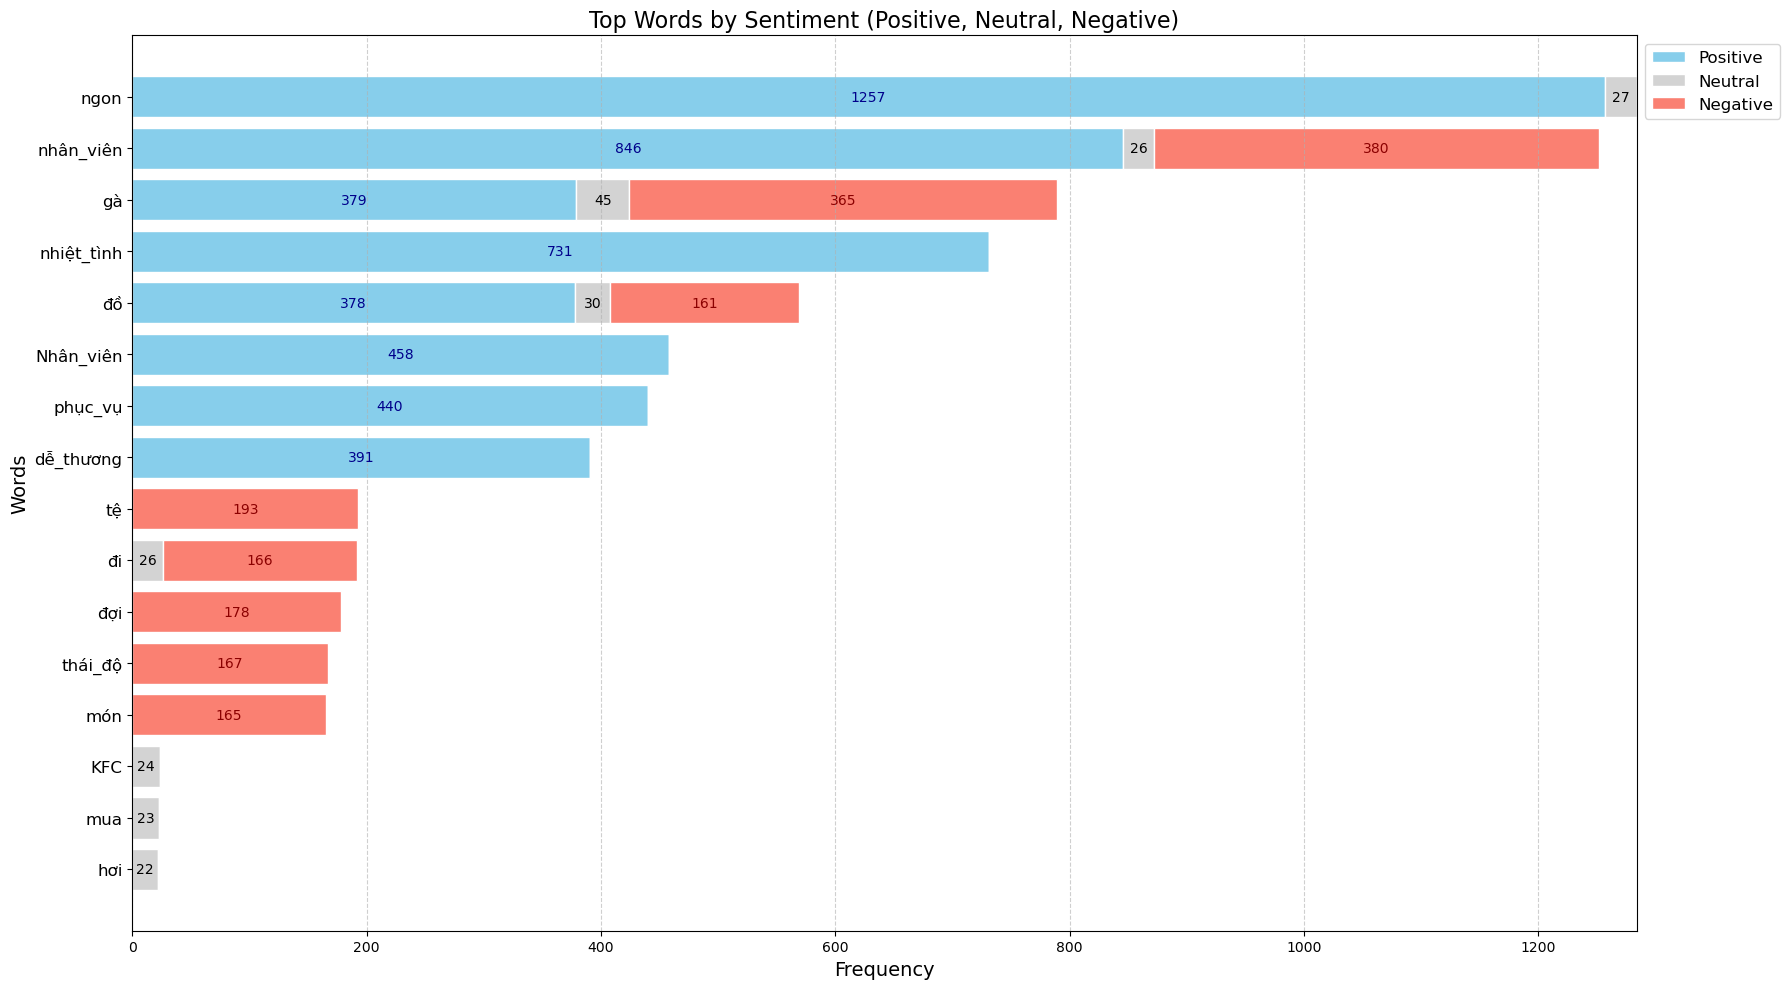

In [ ]:
top_words = {
    sentiment: {
        key[0]: count for key, count in (filtered_sent
            .filter(lambda x: x[0][1] == sentiment)
            .takeOrdered(8, key=lambda x: -x[1])
        )
    }
    for sentiment in ['positive', 'neutral', 'negative']
}

all_words = list(set(
    list(top_words['positive'].keys()) + 
    list(top_words['neutral'].keys()) + 
    list(top_words['negative'].keys())
))

df_plot = pd.DataFrame({
    'Word': all_words,
    'Positive': [top_words['positive'].get(word, 0) for word in all_words],
    'Neutral': [top_words['neutral'].get(word, 0) for word in all_words],
    'Negative': [top_words['negative'].get(word, 0) for word in all_words]
})

df_plot['Total'] = df_plot['Positive'] + df_plot['Neutral'] + df_plot['Negative']
df_plot = df_plot.sort_values('Total', ascending=True)

# Visualize stacked bar
plt.figure(figsize=(18, 10))

p1 = plt.barh(df_plot['Word'], df_plot['Positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(df_plot['Word'], df_plot['Neutral'], 
              left=df_plot['Positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(df_plot['Word'], df_plot['Negative'], 
              left=df_plot['Positive'] + df_plot['Neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, word in enumerate(df_plot['Word']):
    # Positive
    if df_plot['Positive'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i]/2, i,
                str(df_plot['Positive'].iloc[i]), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if df_plot['Neutral'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i]/2, i,
                str(df_plot['Neutral'].iloc[i]), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total_width = df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]
    if df_plot['Negative'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]/2, i,
                str(df_plot['Negative'].iloc[i]), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(df_plot['Word'])), df_plot['Word'], fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top Words by Sentiment (Positive, Neutral, Negative)', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Top Keywords by Rating

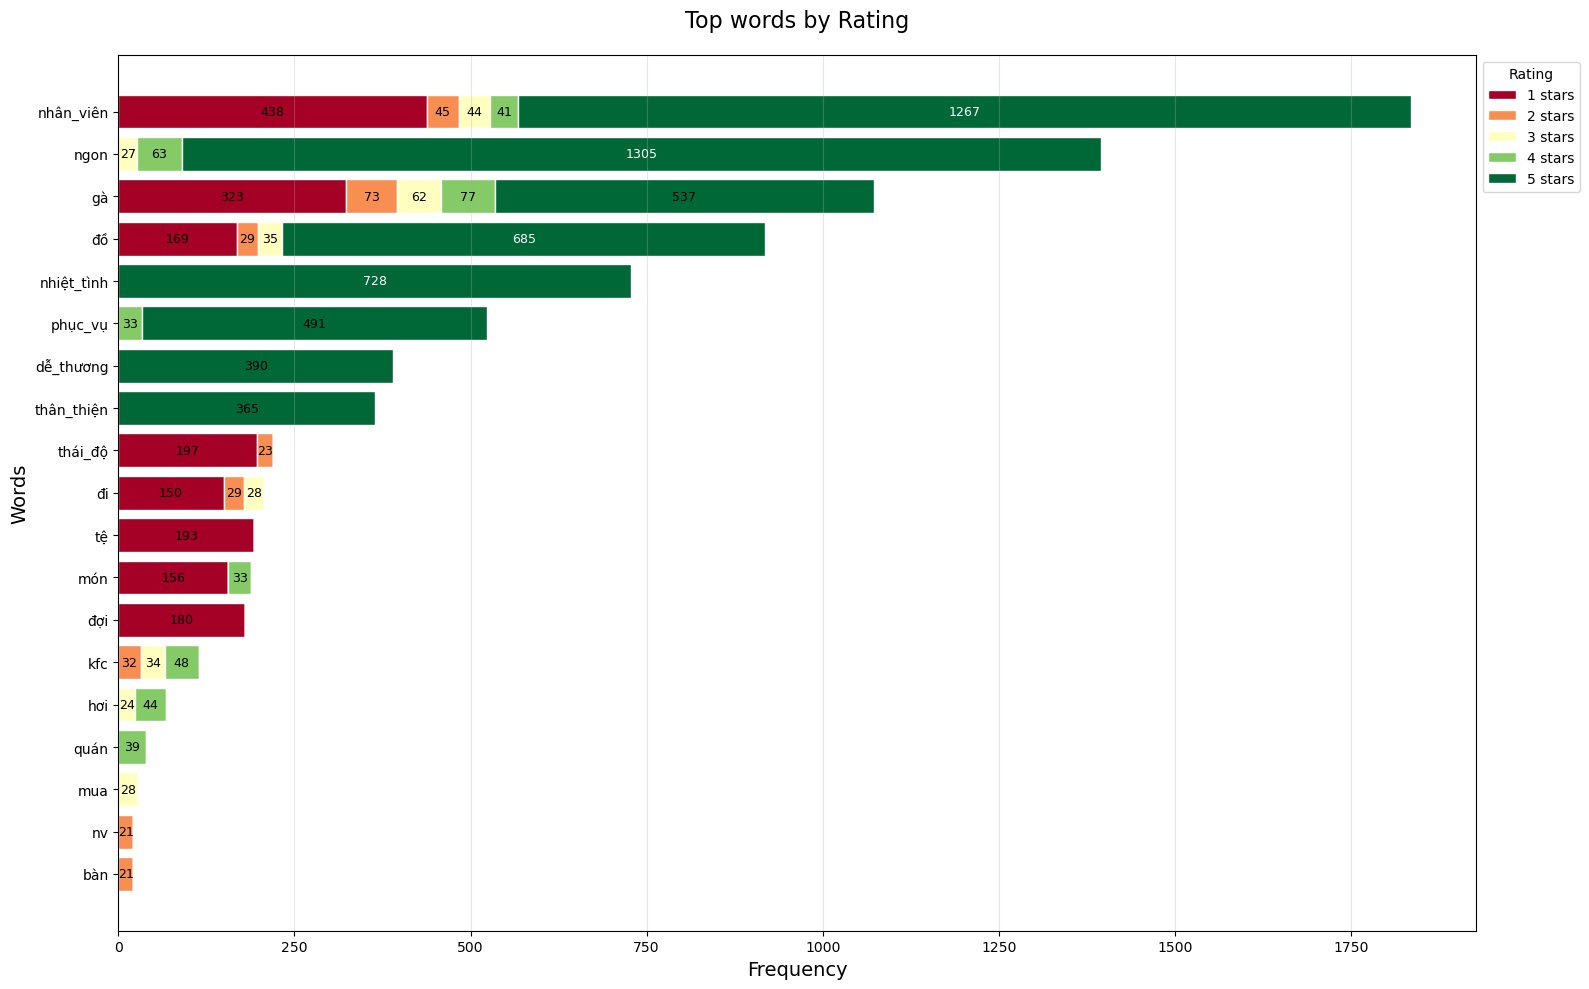

In [ ]:
top_words = {
    rating: {
        key[0]: count for key, count in (filtered_rating
            .filter(lambda x: x[0][1] == rating)
            .takeOrdered(8, key=lambda x: -x[1])
        )
    }
    for rating in range(1, 6)
}

all_words = list(set(
    list(top_words[1].keys()) +
    list(top_words[2].keys()) +
    list(top_words[3].keys()) +
    list(top_words[4].keys()) +
    list(top_words[5].keys())
))

df_plot = pd.DataFrame({'word': all_words})
for rating in top_words:
    df_plot[f'rating_{rating}'] = [top_words[rating].get(word, 0) for word in all_words]


df_plot['total'] = df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].sum(axis=1)
df_plot = df_plot.sort_values('total', ascending=True)

# Visualize stacked chart
plt.figure(figsize=(16, 10))
colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))

left = None
for idx, rating in enumerate(top_words):
    plt.barh(
        df_plot['word'],
        df_plot[f'rating_{rating}'],
        color=colors[idx],
        label=f'{rating} stars',
        left=left,
        edgecolor='white'
    )
    left = df_plot[f'rating_{rating}'] if left is None else left + df_plot[f'rating_{rating}']

for i, word in enumerate(df_plot['word']):
    width = 0
    for rating in top_words:
        value = df_plot[f'rating_{rating}'].iloc[i]
        if value > 0:
            plt.text(
                width + value/2, i,
                str(int(value)), 
                va='center', ha='center',
                color='white' if value > max(df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].max())/2 else 'black',
                fontsize=9
            )
            width += value

plt.title('Top words by Rating', fontsize=16, pad=20)
plt.ylabel('Words', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend(title='Rating', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

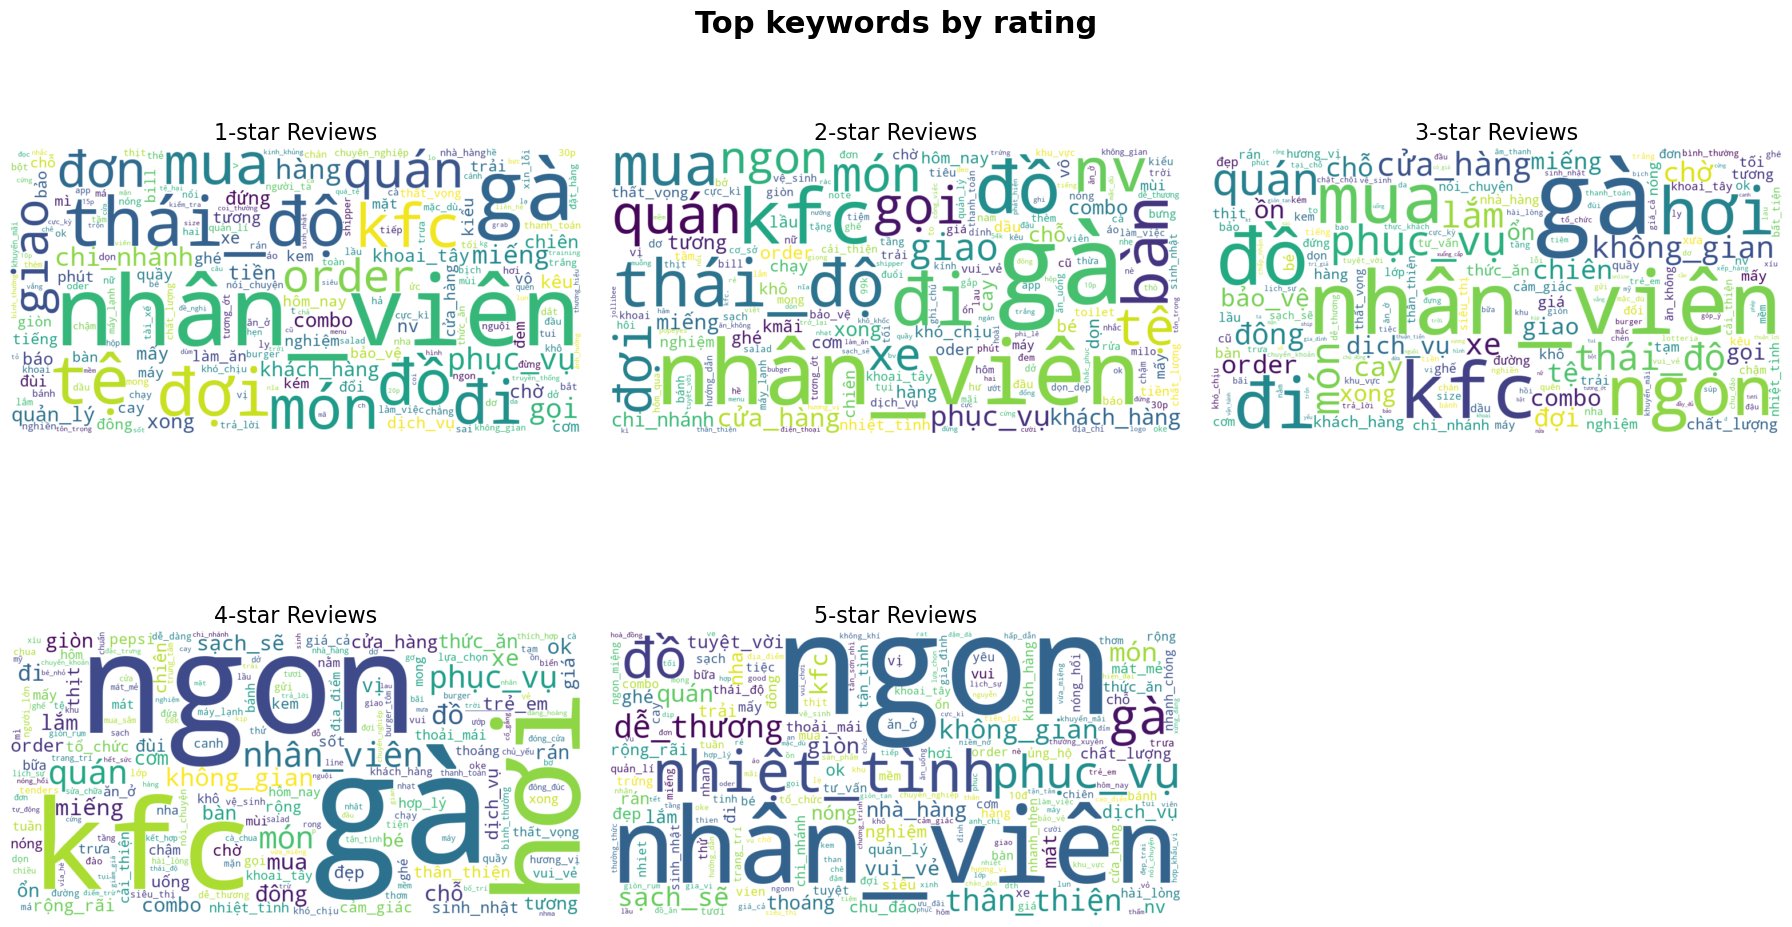

In [ ]:
temp_dict = {
    star: {key[0]: val for key, val in filtered_rating.filter(lambda x: x[0][1] == star).collect()}
    for star in range(1, 6)
}

fig = plt.figure(figsize=(18, 10))
axes = fig.subplot_mosaic([[1, 2, 3], [4, 5, '.']])

fig.tight_layout()
fig.suptitle("Top keywords by rating", fontsize=22, fontweight='bold')
wc = WordCloud(width=1000, height=500, background_color='white', colormap='viridis')
for star, freq_dict in temp_dict.items():
    axes[star].imshow(wc.generate_from_frequencies(temp_dict[star]), interpolation='bilinear')
    axes[star].axis("off")
    axes[star].set_title(f"{star}-star Reviews", fontsize=16)

fig.tight_layout(pad=1.0)
fig.subplots_adjust(top=0.90, hspace=0.2, wspace=0.05)